In [90]:
import itertools
import matplotlib
from operator import itemgetter
import sys
sys.path.append('/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods')
from settings import *
import helpers
import interacting_with_regulondb as ir

%matplotlib inline
config_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/resource_reallocation/config"
config_dict = helpers.process_config(config_file)

# Output
figures_dir = config_dict["out_dir"]["figures"]
results_dir = config_dict["out_dir"]["results"]

# Data
rdb = config_dict["db"]["path"]
cnts_file = config_dict['out_dir']['counts']

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


In [91]:
crp = pd.DataFrame.from_records(ir.get_regulon(rdb, 'crp'), columns=["regulator", "name", "locus_tag", 'function'])
crp.shape

(571, 4)

In [92]:
crp = crp[crp.function == 'activator'].set_index('name')

In [93]:
crp_bnums = crp.locus_tag.values
len(crp_bnums)

425

In [94]:
def get_subset_genes(df, key, col_return,column_name="Function"):
    keep = []
    if not type(key) == str:
        return df[df[column_name].isin(key)][col_return]
    for i, x in zip(df.index, df[column_name]):
        if not type(x) == str:
            continue
        if key in x:
            keep.append(i)
    return df.loc[keep][col_return]

df = pd.read_csv(config_dict['out_dir']['de_edited_file'], index_col=0)
rprotein = get_subset_genes(df, "ribosomal subunit protein", df.columns).index
len(rprotein)

48

In [34]:
#...
with open ("/Users/annasintsova/git_repos/HUTI-RNAseq/"\
           "results/resource_allocation/"\
           "2018-04-16_eco_ribosomal_subunit.kegg.results", "r") as fh:
    ribosome_genes = [line.split()[0].rstrip().split(":")[1].strip() for line in fh]
    
with open ("/Users/annasintsova/git_repos/HUTI-RNAseq/"\
           "results/resource_allocation/"\
           "2018-04-13_crp_activator_info.tab", "r") as fh:
    crp_genes = [line.split()[0].rstrip() for line in fh]

In [95]:
cnts = pd.read_csv(cnts_file, index_col=0)
to_keep = [c for c in cnts.columns if 'count' in c]
cnts = cnts[to_keep]
core_cnts = cnts.sum() # counts dedicated to core genome expression
ribosome_counts = cnts.loc[rprotein]
ribosome_sum = ribosome_counts.sum()
crp_in_core = set(crp_bnums).intersection(set(cnts.index))
crp_counts = cnts.loc[crp_in_core]
crp_sum = crp_counts.sum()

In [97]:
totals =  pd.DataFrame({'Core': core_cnts,'R-protein':ribosome_sum, 'Catabolic genes': crp_sum})
totals["C%"] = round(totals["Catabolic genes"]/totals["Core"]*100,2)
totals["R%"] = round(totals["R-protein"]/totals["Core"]*100,2)
totals['Sample'] = [ur  if 'UR' in c else uti for c in totals.index]
totals


,Core,R-protein,Catabolic genes,C%,R%,Sample
HM01_UR_count,8339516.0,364511.0,2229966.0,26.74,4.37,URINE
HM01_UTI_count,2270040.0,605552.0,260645.0,11.48,26.68,PATIENT
HM03_UR_count,11344027.0,523235.0,2561484.0,22.58,4.61,URINE
HM03_UTI_count,4913506.0,1397637.0,643289.0,13.09,28.44,PATIENT
HM06_UR_count,11789016.0,883421.0,2478077.0,21.02,7.49,URINE
HM06_UTI_count,2606614.0,506208.0,303138.0,11.63,19.42,PATIENT
HM07_UR_count,10917809.0,480849.0,2156924.0,19.76,4.40,URINE
HM07_UTI_count,1136237.0,253247.0,132565.0,11.67,22.29,PATIENT
HM14_UR_count,11278572.0,512872.0,2786211.0,24.70,4.55,URINE
HM14_UTI_count,7774529.0,2139952.0,1071556.0,13.78,27.53,PATIENT


In [100]:
flag = pd.read_csv(config_dict['flagstat']['summary'], index_col=0)
flag
flag.index = [f.split("_trimmed")[0]+"_count" for f in flag.index]
mapped = flag.loc[totals.index]['mapped']
totals['mapped'] = mapped
totals['% core'] = round(totals["Core"]/totals['mapped']*100, 2)
totals.to_csv(os.path.join(results_dir, "percent_allocated.csv"))

Text(0,0.5,'% Core Genome Reads')

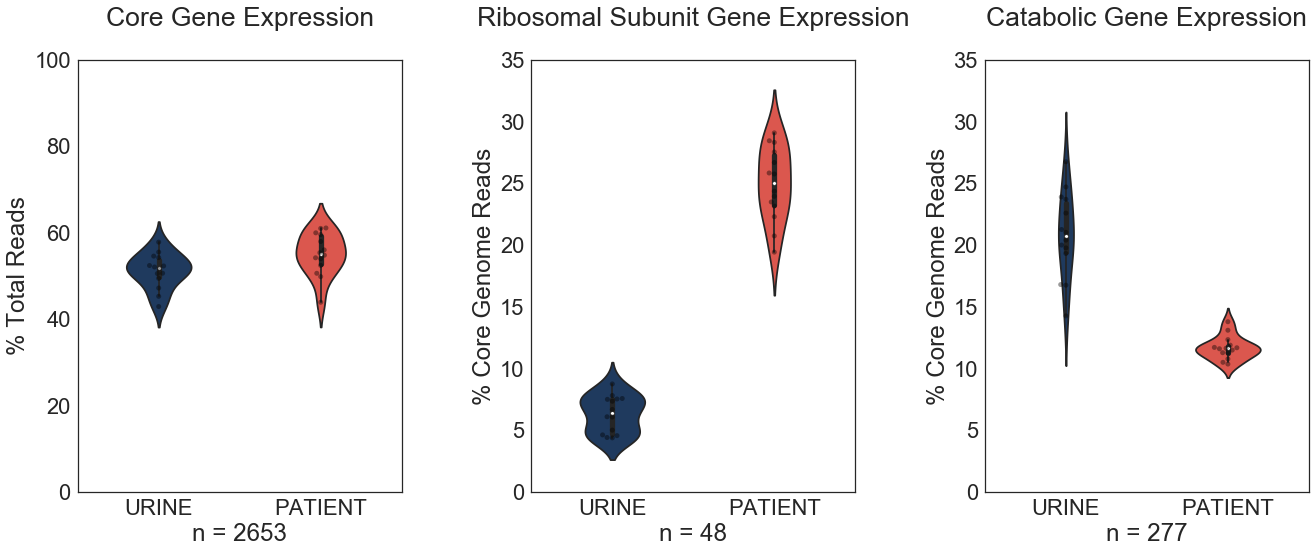

In [88]:
fig = plt.figure(figsize=(9,5))

sns.set(font_scale = 2.2)
sns.set_style("white")
# Core Gene Expression
ax1 = fig.add_axes([0.1, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 100))
sns.violinplot(x = "Sample", y = "% core", palette=[col5, col1],data = totals,width=0.4)
sns.swarmplot(x = "Sample", y = "% core", data = totals, color = 'black', alpha = 0.4)
ax1.set_title("Core Gene Expression\n")
ax1.set_xticklabels([ur, uti])
ax1.set_xlabel("n = {}".format(cnts.shape[0]))
ax1.set_ylabel("% Total Reads")

# Ribosome Subunits Gene Expression

ax2 = fig.add_axes([0.8, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 35))
sns.violinplot(x = "Sample", y = "R%",palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "R%", data =totals, color = 'black', alpha = 0.4)
ax2.set_title("Ribosomal Subunit Gene Expression\n")
ax2.set_xticklabels([ur, uti])
ax2.set_xlabel("n = {}".format(len(rprotein)))
ax2.set_ylabel("% Core Genome Reads")

# Catabolic Gene Expression

ax3 = fig.add_axes([1.5, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 35))
sns.violinplot(x = "Sample", y = "C%", palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "C%", data =totals, color = 'black', alpha = 0.4)
ax3.set_title("Catabolic Gene Expression\n")
ax3.set_xticklabels([ur, uti])
ax3.set_xlabel("n = {}".format(len(crp_in_core)))
ax3.set_ylabel("% Core Genome Reads")
#fig.savefig(os.path.join(figures_dir, "Figure_5.png"),bbox_inches='tight',dpi=500 )